20.2 图像融合

步骤：

1.读入两幅图像，苹果和橘子（要保证输入图片的大小size一样，可用resize(）函数）

2.构建苹果和橘子的高斯金字塔（6层）

3.根据高斯金字塔计算拉普拉斯金字塔

4.在拉普拉斯的每一层进行图像融合（苹果的左边与右边融合）

5.根据融合后的图像金字塔重建原始图像

会出现错误，修改：

https://stackoverflow.com/questions/32970397/opencv-errorsizes-of-input-arguments-do-not-match/32970947

A size
(19, 19)
A size
(38, 38)
A size
(75, 75)
A size
(150, 150)
A size
(300, 300)
B size
(19, 19)
B size
(38, 38)
B size
(75, 75)
B size
(150, 150)
B size
(300, 300)


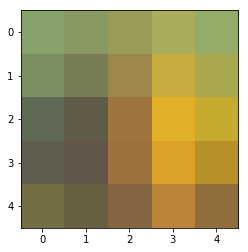

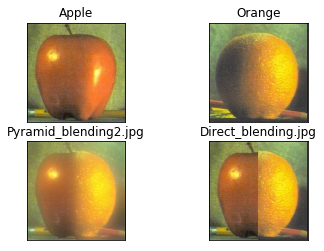

In [2]:
import  cv2
import numpy as np
import matplotlib.pyplot as plt

#1.读入两幅图像
A = cv2.imread('image/apple.jpg')
b,g,r = cv2.split(A)
A1 = cv2.merge([r,g,b])

B = cv2.imread('image/orange.jpg')
b,g,r = cv2.split(B)
B1 = cv2.merge([r,g,b])

#缩放到同一个尺寸
A=cv2.resize(A1,(300,300),interpolation=cv2.INTER_CUBIC)
B=cv2.resize(B1,(300,300),interpolation=cv2.INTER_CUBIC)

#2.构建苹果的高斯金字塔（6层）
#2 generate Gaussian pyramid for A
G = A.copy()
#print(G)
gpA = [G]
#print(gpA)
for i in xrange(6):
    #G = cv2.pyrDown(G) #error!!!
    #你必须把它应用在最后一个向下采样的图像上
    G = cv2.pyrDown(gpA[i])
    gpA.append(G)

#generate Gaussian pyramid for B 
G = B.copy()
gpB = [G]
for i in xrange(6):
    #G = cv2.pyrDown(G)
    G = cv2.pyrDown(gpB[i])
    gpB.append(G)
    
#3. 根据高斯金字塔计算拉普拉斯金字塔    
# 3 generate Laplacian Pyramid for A
'''
lpA = [gpA[5]]
for i in xrange(5,0,-1):
    GE = cv2.pyrUp(gpA[i])
    L = cv2.subtract(gpA[i-1],GE)
    lpA.append(L)
'''    
lpA = [gpA[5]]
for i in xrange(5,0,-1):
    size = (gpA[i-1].shape[1], gpA[i-1].shape[0])
    print('A size')
    print(size)
    GE = cv2.pyrUp(gpA[i], dstsize = size)
    L = cv2.subtract(gpA[i-1],GE)
    lpA.append(L)    
    
    
# generate Laplacian Pyramid for B
'''
lpB = [gpB[5]]
for i in xrange(5,0,-1):
    GE = cv2.pyrUp(gpB[i])
    L = cv2.subtract(gpB[i-1],GE)
    lpB.append(L)
'''
lpB = [gpB[5]]
for i in xrange(5,0,-1):
    size = (gpB[i-1].shape[1], gpB[i-1].shape[0])
    print('B size')
    print(size)
    GE = cv2.pyrUp(gpB[i], dstsize = size)
    L =cv2.subtract(gpB[i-1],GE)
    lpB.append(L)

#4 Now add left and right halves of images in each level
#numpy.hstack(tup)
#Take a sequence of arrays and stack them horizontally
#to make a single array.
#将两个图像的矩阵的左半部分和右半部分拼接到一起  
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    #苹果的左半部分和橘子的右半部分
    ls = np.hstack((la[:,0:cols/2], lb[:,cols/2:]))
    #苹果的右半部分和橘子的左半部分
    #ls = np.hstack((la[:,cols/2:], lb[:,0:cols/2])) 
    #橘子的左半部分和苹果的右半部分
    #ls =np.hstack((lb[:,0:cols/2],la[:,cols/2:]))
    
    #输入数组维度必须完全匹配，所以原来的输入图片尺寸要一样  
    LS.append(ls)

#5  now reconstruct
'''
ls_ = LS[0]
for i in xrange(1,6):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])
'''    
ls_ = LS[0]
for i in xrange(1,6):
    size = (LS[i].shape[1], LS[i].shape[0])
    ls_ = cv2.pyrUp(ls_, dstsize = size)
    ls_ = cv2.add(ls_, LS[i])    
    
# image with direct connecting each half
real = np.hstack((A[:,:cols/2],B[:,cols/2:]))


b,g,r = cv2.split(ls_)
ls_1 = cv2.merge([r,g,b])

b,g,r = cv2.split(real)
real_1 = cv2.merge([r,g,b])

cv2.imwrite('image/Pyramid_blending2_rgb.jpg',ls_1)
cv2.imwrite('image/Direct_blending_rgb.jpg',real_1)

cv2.imwrite('image/Pyramid_blending2_bgr.jpg',ls_)
cv2.imwrite('image/Direct_blending_bgr.jpg',real)

plt.imshow(G)
plt.show()

plt.subplot(221),plt.imshow(A),plt.title('Apple')
plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(B),plt.title('Orange')
plt.xticks([]), plt.yticks([])

plt.subplot(223),plt.imshow(ls_),plt.title('Pyramid_blending2.jpg')
plt.xticks([]), plt.yticks([])

plt.subplot(224),plt.imshow(real),plt.title('Direct_blending.jpg')
plt.xticks([]), plt.yticks([])
plt.show()